In [1]:
##################################################################################
#                      DNN Training for CMS Run 2 H->mu mu                       #
#                      Written by : Irene Dutta , Caltech                        #
#                          Email : idutta@caltech.edu                            #
#                     Code first written on : 01 Aug,2019                        #
#  This code is an intellectual property of the author and the Caltech CMS group #
#                Please ask for permission before using this code.               #
##################################################################################

In [2]:
import ROOT as rt
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
from math import pow
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.18/00
setGPU: Setting GPU to: 1


In [3]:
variables = ['softJet5', 'dRmm','dEtamm','M_jj','pt_jj','eta_jj','phi_jj','M_mmjj','eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
                                   ,'dRmin_mmj','dRmax_mmj','dPhimm','leadingJet_pt','subleadingJet_pt',
                                   'leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS','Higgs_pt','Higgs_eta','Higgs_mass']
id_variables = ['run','lumi','event']
wt_variables = ['genweight']
mass_variables = ['Higgs_mass']
dijet_genmass_variables=['dijet_inv_mass_gen']
oldDNN=['dnn_pred']
ucsdBDT=['bdt_ucsd']

# Load data

In [4]:
main_path ='/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/'
bkg_1='dy_m105_160_vbf_amc_'
bkg_2='dy_m105_160_amc_'
bkg_3 ='ewk_lljj_mll105_160_'
sig_1 = 'vbf_powheg1'
sig_2 = 'vbf_powheg2'
sig_3 = 'vbf_'
sig_4 = 'ggh_'
ext = '.npy'
bkgnp = np.array([])
bkg1_frame =[]
bkg2_frame =[]
bkg3_frame =[]
sig1_frame =[]
sig2_frame =[]
sig3_frame =[]
sig4_frame =[]
directory = os.listdir(main_path)

for name in directory:
    #print(name)
    if (ext) not in (name):
        continue
    if (main_path+bkg_1) in (main_path+name):
        print(main_path+name)
        fp =np.load(main_path+name)

        df = pd.DataFrame.from_records(fp)
        df_nonVBF = df[ (df['cat_index'] !=5) | (df['M_jj']<400.) | (df['Higgs_mass']<110.) | (df['Higgs_mass']>150.)]
        df = df.drop(df_nonVBF.index,axis=0)
        df = df.dropna()
        bkg1_frame.append(df)
        continue
    if (main_path+bkg_2) in (main_path+name):
        print(main_path+name)
        fp_1 =np.load(main_path+name)
        df_1 = pd.DataFrame.from_records(fp_1)
        df_1_nonVBF = df_1[ (df_1['cat_index'] !=5) | (df_1['M_jj']<400.) | (df_1['Higgs_mass']<110.) | (df_1['Higgs_mass']>150.)]

       
        df_1 = df_1.drop(df_1_nonVBF.index,axis=0)

        df_1 = df_1.dropna()
        bkg2_frame.append(df_1)
        continue   
    if (main_path+bkg_3) in (main_path+name):
        print(main_path+name)
        fp_2 =np.load(main_path+name)
        df_2 = pd.DataFrame.from_records(fp_2)
        df_2_nonVBF = df_2[ (df_2['cat_index'] !=5) |  (df_2['M_jj']<400.) | (df_2['Higgs_mass']<110.) | (df_2['Higgs_mass']>150.)]

       
        df_2 = df_2.drop(df_2_nonVBF.index,axis=0)

        df_2 = df_2.dropna()
        bkg3_frame.append(df_2)
        continue  
        
    if (main_path+sig_1) in (main_path+name):
        print(main_path+name)
        fp_3 =np.load(main_path+name)
        df_3 = pd.DataFrame.from_records(fp_3)

        df_3_nonVBF = df_3[ (df_3['cat_index'] !=5) | (df_3['M_jj']<400.) | (df_3['Higgs_mass']<110.) | (df_3['Higgs_mass']>150.)]
        df_3 = df_3.drop(df_3_nonVBF.index,axis=0)
        df_3 = df_3.dropna()
        sig1_frame.append(df_3)
        continue
    
    if (main_path+sig_2) in (main_path+name):
        print(main_path+name)
        fp_4 =np.load(main_path+name)
        df_4 = pd.DataFrame.from_records(fp_4)

        df_4_nonVBF = df_4[ (df_4['cat_index'] !=5) | (df_4['M_jj']<400.) | (df_4['Higgs_mass']<110.) | (df_4['Higgs_mass']>150.)]
        df_4 = df_4.drop(df_4_nonVBF.index,axis=0)
        df_4 = df_4.dropna()
        sig2_frame.append(df_4)
        continue 
        
    if (main_path+sig_3) in (main_path+name):
        print(main_path+name)
        fp_5 =np.load(main_path+name)
        df_5 = pd.DataFrame.from_records(fp_5)

        df_5_nonVBF = df_5[ (df_5['cat_index'] !=5) | (df_5['M_jj']<400.) | (df_5['Higgs_mass']<110.) | (df_5['Higgs_mass']>150.)]
        df_5 = df_5.drop(df_5_nonVBF.index,axis=0)
        df_5 = df_5.dropna()
        sig3_frame.append(df_5)
        continue
        
    if (main_path+sig_4) in (main_path+name):
        print(main_path+name)
        fp_6 =np.load(main_path+name)
        df_6 = pd.DataFrame.from_records(fp_6)

        df_6_nonVBF = df_6[ (df_6['cat_index'] !=5) | (df_6['M_jj']<400.) | (df_6['Higgs_mass']<110.) | (df_6['Higgs_mass']>150.)]
        df_6 = df_6.drop(df_6_nonVBF.index,axis=0)
        df_6 = df_6.dropna()
        sig4_frame.append(df_6)
        continue
bkg1_full_frame = pd.concat(bkg1_frame)   
bkg2_full_frame = pd.concat(bkg2_frame)
bkg3_full_frame = pd.concat(bkg3_frame)
sig1_full_frame = pd.concat(sig1_frame)
sig2_full_frame = pd.concat(sig2_frame)
sig3_full_frame = pd.concat(sig3_frame)
sig4_full_frame = pd.concat(sig4_frame)
#print sig1_full_frame.head()



/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_vbf_amc_23.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_vbf_amc_28.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_amc_5.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_amc_41.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_amc_16.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/ewk_lljj_mll105_160_83.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_amc_22.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/ewk_lljj_mll105_160_59.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_vbf_amc_22.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/dy_m105_160_amc_31.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/dnn_vars/2016/ewk_lljj_mll105_160_82.npy
/storage/user/nlu/hmm/2019_08_20_jetpt_l30

In [5]:
sig1_full_frame.head()
#print(sig1_full_frame[sig1_full_frame.duplicated()])

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
1,-0.049316,-1.720032,1.720739,436.746918,181.054245,-1.941795,2.278031,663.566040,-3.851227,2.188433,...,-1.076416,1.126242,0.386080,0.821868,5,1,1,11,0.818756,3.74429
2,-0.949463,2.962891,3.111302,1623.873047,52.187126,-1.880121,2.290674,1927.688110,2.528921,1.507206,...,2.083984,0.778094,0.260190,0.848411,5,1,1,18,0.982836,3.74429
4,0.995178,2.283772,2.491183,479.444214,52.074181,-1.811104,1.547944,699.519104,-1.576329,2.019669,...,0.234314,0.632860,0.360508,0.827781,5,1,1,22,0.832584,3.74429
5,1.265625,-2.834821,3.104516,505.228363,35.130230,-3.367845,1.611056,642.181580,-3.850611,1.941411,...,-0.936401,0.427182,0.408252,-0.925747,5,1,1,17,0.109196,3.74429
6,0.808594,1.927856,2.090563,2311.249023,82.136047,-3.850335,1.413246,2698.386230,-7.460730,2.862397,...,0.437256,0.628108,0.469740,0.833938,5,1,1,28,0.986767,3.74429


In [6]:
sig2_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
0,0.499023,-1.402344,1.488487,507.453888,170.756485,-0.775662,2.670542,960.112427,-3.698957,0.458213,...,-2.161621,1.485772,0.350744,0.833318,5,1,1,3,0.792014,3.74429
2,0.427429,1.621826,1.677205,575.282837,113.155350,2.024543,1.192532,792.796814,3.118304,2.007199,...,0.433411,1.311673,0.333280,0.858418,5,1,1,1,0.817113,3.74429
3,0.813538,2.751099,2.868865,843.966858,57.871838,2.495430,2.883652,984.635803,3.217053,2.523342,...,-0.476257,0.573361,0.383436,0.777209,5,1,1,17,0.795180,3.74429
4,-1.201599,1.381592,1.831021,1130.329102,170.328033,-2.525345,0.894429,1369.569824,-5.470243,1.072365,...,-0.392151,1.181961,0.260322,0.914482,5,1,1,18,0.984776,3.74429
6,0.601074,1.678101,1.782502,1119.165649,86.608299,0.698840,3.094777,1595.775146,-4.036548,0.277638,...,-2.202637,0.668086,0.578701,0.643931,5,1,1,25,0.874811,3.74429


In [7]:
sig3_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
1,-1.061279,2.526978,2.740790,535.027832,72.304291,-2.265125,1.533186,721.834167,-5.326693,1.667614,...,-0.569580,0.814169,0.252201,0.885861,5,1,1,10,0.934318,12.64652
2,-1.212585,-0.478464,1.303569,1414.298828,184.239319,2.411048,2.846662,1660.912354,6.257684,0.943823,...,1.664551,0.878339,0.604244,0.679017,5,1,1,12,0.960646,-12.64652
4,-0.155251,-2.662824,2.667346,1256.316284,49.504997,2.329978,0.980680,1386.955933,2.622629,1.695103,...,0.198944,0.558427,0.471337,0.924298,5,1,1,16,0.981595,12.64652
7,-0.943481,1.441388,1.722718,1412.892456,169.378036,2.267761,0.076766,1637.888672,4.244513,0.649261,...,1.751953,1.100097,0.336659,0.954635,5,1,1,8,0.978476,12.64652
8,0.060730,-1.525635,1.526843,561.106262,129.626404,-2.327162,2.837407,803.195435,-4.868524,0.328612,...,-0.252991,0.952592,0.548639,0.880552,5,1,1,21,0.960986,-12.64652


## Use the correction cross section weights

In [8]:
import json
with open('/storage/user/nlu/hmm/2019_08_20_jetpt_l30_sl30/baseline/plots/2016/normalization.json') as json_file:
    data = json.load(json_file)
#print(data['weight_xs']['vbf'])
sig4_full_frame['genweight']=sig4_full_frame['genweight']*data['weight_xs']['ggh']
sig3_full_frame['genweight']=sig3_full_frame['genweight']*data['weight_xs']['vbf']*data['genweights']['vbf']/(data['genweights']['vbf']+data['genweights']['vbf_powheg2']+data['genweights']['vbf_powheg1'])
sig2_full_frame['genweight']=sig2_full_frame['genweight']*data['weight_xs']['vbf_powheg2']*data['genweights']['vbf_powheg2']/(data['genweights']['vbf']+data['genweights']['vbf_powheg2']+data['genweights']['vbf_powheg1'])
sig1_full_frame['genweight']=sig1_full_frame['genweight']*data['weight_xs']['vbf_powheg1']*data['genweights']['vbf_powheg1']/(data['genweights']['vbf']+data['genweights']['vbf_powheg2']+data['genweights']['vbf_powheg1'])

bkg2_full_frame['genweight']=bkg2_full_frame['genweight']*data['weight_xs']['dy_m105_160_amc']
bkg1_full_frame['genweight']=bkg1_full_frame['genweight']*data['weight_xs']['dy_m105_160_vbf_amc']
bkg3_full_frame['genweight']=bkg3_full_frame['genweight']*data['weight_xs']['ewk_lljj_mll105_160']



In [9]:
sig3_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
1,-1.061279,2.526978,2.740790,535.027832,72.304291,-2.265125,1.533186,721.834167,-5.326693,1.667614,...,-0.569580,0.814169,0.252201,0.885861,5,1,1,10,0.934318,0.000074
2,-1.212585,-0.478464,1.303569,1414.298828,184.239319,2.411048,2.846662,1660.912354,6.257684,0.943823,...,1.664551,0.878339,0.604244,0.679017,5,1,1,12,0.960646,-0.000074
4,-0.155251,-2.662824,2.667346,1256.316284,49.504997,2.329978,0.980680,1386.955933,2.622629,1.695103,...,0.198944,0.558427,0.471337,0.924298,5,1,1,16,0.981595,0.000074
7,-0.943481,1.441388,1.722718,1412.892456,169.378036,2.267761,0.076766,1637.888672,4.244513,0.649261,...,1.751953,1.100097,0.336659,0.954635,5,1,1,8,0.978476,0.000074
8,0.060730,-1.525635,1.526843,561.106262,129.626404,-2.327162,2.837407,803.195435,-4.868524,0.328612,...,-0.252991,0.952592,0.548639,0.880552,5,1,1,21,0.960986,-0.000074


In [10]:
sig1_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
1,-0.049316,-1.720032,1.720739,436.746918,181.054245,-1.941795,2.278031,663.566040,-3.851227,2.188433,...,-1.076416,1.126242,0.386080,0.821868,5,1,1,11,0.818756,0.000022
2,-0.949463,2.962891,3.111302,1623.873047,52.187126,-1.880121,2.290674,1927.688110,2.528921,1.507206,...,2.083984,0.778094,0.260190,0.848411,5,1,1,18,0.982836,0.000022
4,0.995178,2.283772,2.491183,479.444214,52.074181,-1.811104,1.547944,699.519104,-1.576329,2.019669,...,0.234314,0.632860,0.360508,0.827781,5,1,1,22,0.832584,0.000022
5,1.265625,-2.834821,3.104516,505.228363,35.130230,-3.367845,1.611056,642.181580,-3.850611,1.941411,...,-0.936401,0.427182,0.408252,-0.925747,5,1,1,17,0.109196,0.000022
6,0.808594,1.927856,2.090563,2311.249023,82.136047,-3.850335,1.413246,2698.386230,-7.460730,2.862397,...,0.437256,0.628108,0.469740,0.833938,5,1,1,28,0.986767,0.000022


In [11]:
sig2_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
0,0.499023,-1.402344,1.488487,507.453888,170.756485,-0.775662,2.670542,960.112427,-3.698957,0.458213,...,-2.161621,1.485772,0.350744,0.833318,5,1,1,3,0.792014,0.000022
2,0.427429,1.621826,1.677205,575.282837,113.155350,2.024543,1.192532,792.796814,3.118304,2.007199,...,0.433411,1.311673,0.333280,0.858418,5,1,1,1,0.817113,0.000022
3,0.813538,2.751099,2.868865,843.966858,57.871838,2.495430,2.883652,984.635803,3.217053,2.523342,...,-0.476257,0.573361,0.383436,0.777209,5,1,1,17,0.795180,0.000022
4,-1.201599,1.381592,1.831021,1130.329102,170.328033,-2.525345,0.894429,1369.569824,-5.470243,1.072365,...,-0.392151,1.181961,0.260322,0.914482,5,1,1,18,0.984776,0.000022
6,0.601074,1.678101,1.782502,1119.165649,86.608299,0.698840,3.094777,1595.775146,-4.036548,0.277638,...,-2.202637,0.668086,0.578701,0.643931,5,1,1,25,0.874811,0.000022


## Check variables used in training before standardization

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


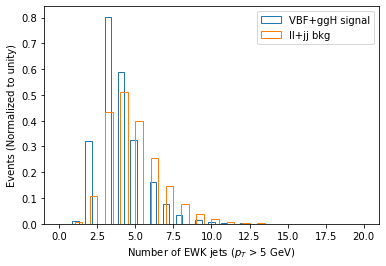

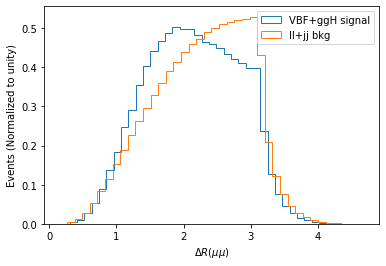

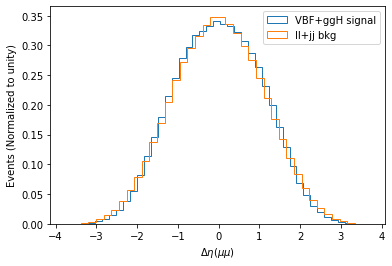

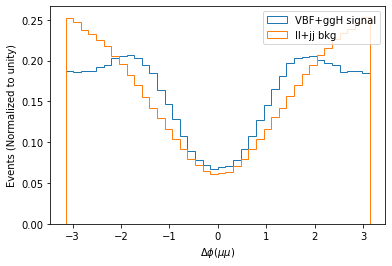

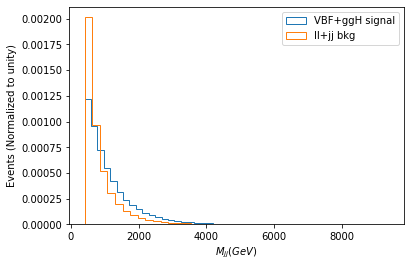

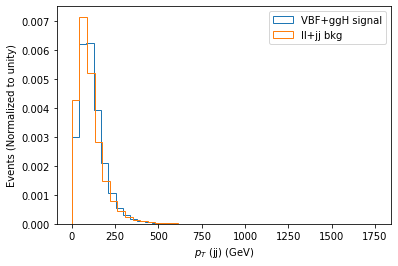

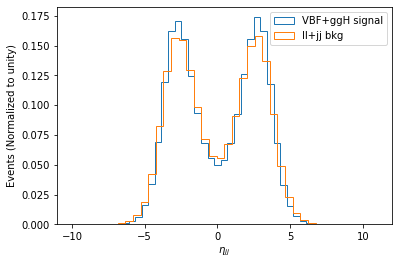

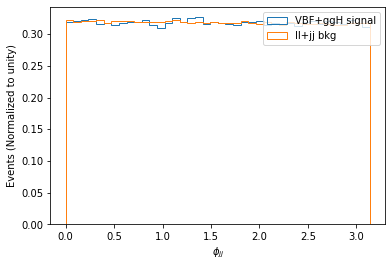

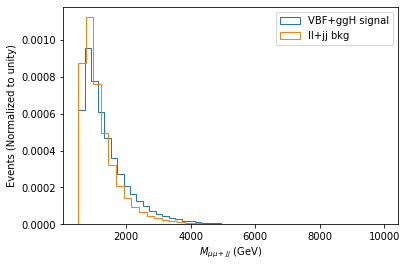

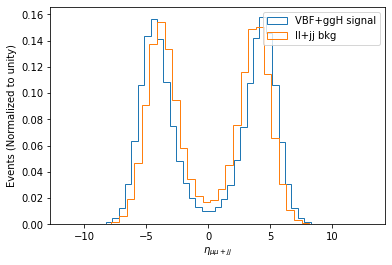

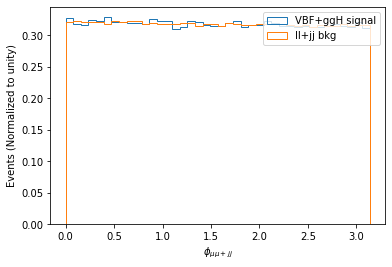

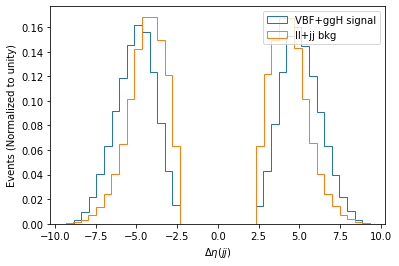

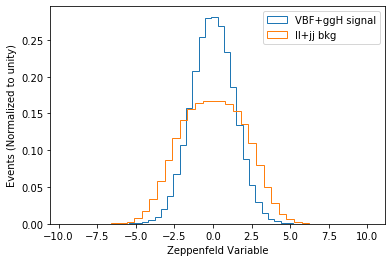

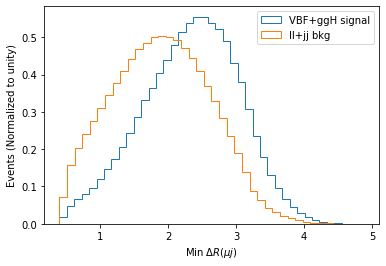

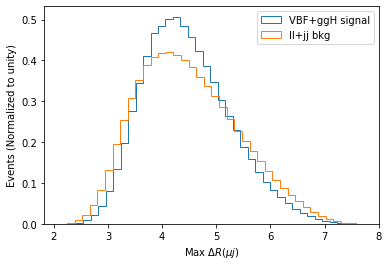

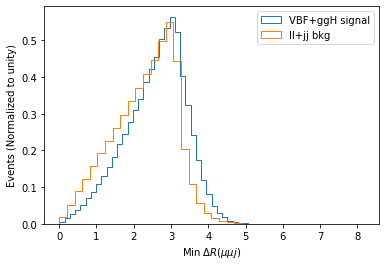

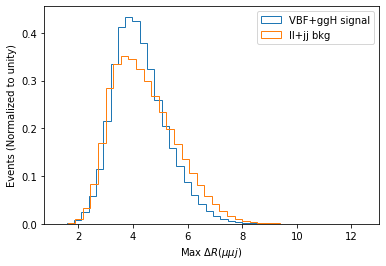

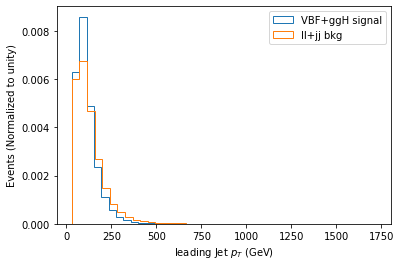

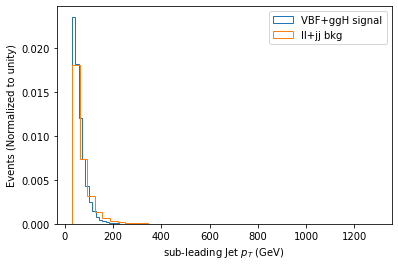

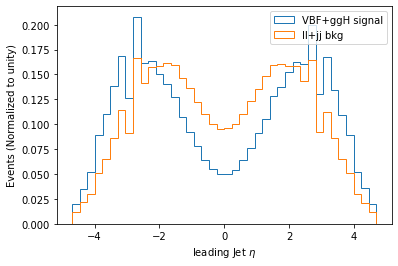

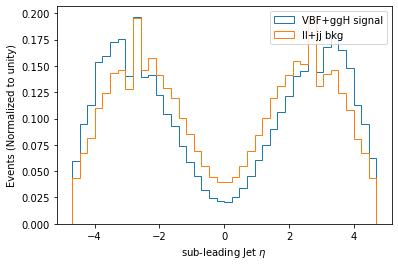

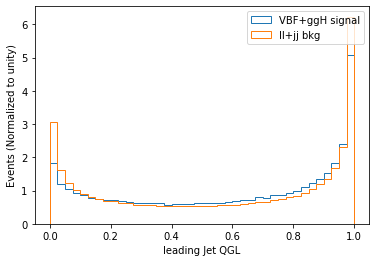

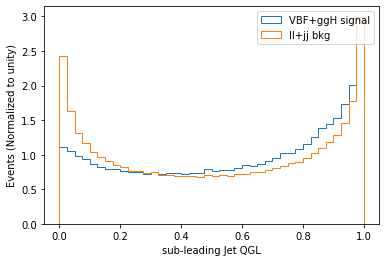

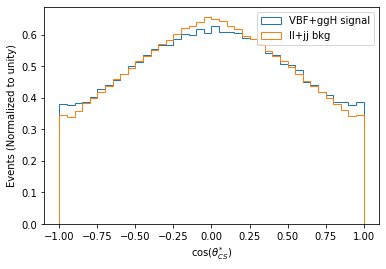

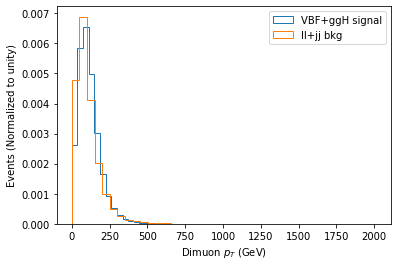

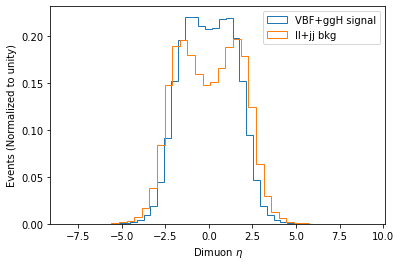

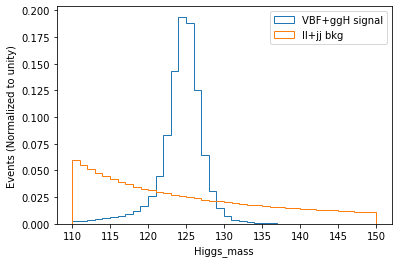

In [12]:
frames = [bkg1_full_frame,bkg2_full_frame,bkg3_full_frame]
background_full_frame = pd.concat(frames)
background_full = background_full_frame.values
sig_frames = [sig1_full_frame,sig2_full_frame,sig3_full_frame,sig4_full_frame]
#sig_frames = [sig1_full_frame,sig2_full_frame,sig3_full_frame]
sig_full_frame = pd.concat(sig_frames)
#although mass is plotted, it's not given to the training
HLF = ['softJet5','dRmm','dEtamm','dPhimm','M_jj','pt_jj','eta_jj','phi_jj','M_mmjj','eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj','dRmin_mmj','dRmax_mmj',
        'leadingJet_pt','subleadingJet_pt','leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS','Higgs_pt',
        'Higgs_eta','Higgs_mass']
xlabel_HLF= ['Number of EWK jets ($p_{T}$ > 5 GeV)','$\Delta R(\mu \mu)$','$\Delta \eta(\mu \mu)$','$\Delta \phi(\mu \mu)$','$M_{jj} (GeV)$','$p_{T}$ (jj) (GeV)','$\eta_{jj}$','$\phi_{jj}$','$M_{\mu\mu + jj}$ (GeV)','$\eta_{\mu\mu + jj}$','$\phi_{\mu\mu + jj}$','$\Delta \eta(jj)$','Zeppenfeld Variable','Min $\Delta R(\mu j)$ ', 'Max $\Delta R(\mu j)$','Min $\Delta R(\mu \mu j)$','Max $\Delta R(\mu \mu j)$',
             'leading Jet $p_{T}$ (GeV)','sub-leading Jet $p_{T}$ (GeV)','leading Jet $\eta$','sub-leading Jet $\eta$','leading Jet QGL','sub-leading Jet QGL','cos($\\theta_{CS}^{*}$)','Dimuon $p_{T}$ (GeV)',
        'Dimuon $\eta$','Higgs_mass']
for hlf,xlabel_hlf in zip(HLF,xlabel_HLF):
    plt.figure()
    plt.hist(sig_full_frame[hlf], bins=40, normed=True, histtype='step', label='VBF+ggH signal')
    plt.hist(background_full_frame[hlf], bins=40, normed=True, histtype='step', label='ll+jj bkg')
    plt.xlabel(xlabel_hlf)
    plt.ylabel('Events (Normalized to unity)')
    plt.legend(loc='best')
    plt.savefig("/bigdata/shared/idutta/hmm_numpy/Higgs_plots/SigBkgCompare_"+hlf+".png")

## Standardization

In [13]:

var_indices = [sig1_full_frame.columns.get_loc(v) for v in variables] # get positions of all the variables set above
id_var_indices = [sig1_full_frame.columns.get_loc(v) for v in id_variables]
wt_var_indices = [sig1_full_frame.columns.get_loc(v) for v in wt_variables]
mass_var_indices = [sig1_full_frame.columns.get_loc(v) for v in mass_variables]
oldDNN_indices = [sig1_full_frame.columns.get_loc(v) for v in oldDNN]
ucsdBDT_indices = [sig1_full_frame.columns.get_loc(v) for v in ucsdBDT]
'''
# Standardize only the actual variables not event ID or genweights
x_mean_sig1 = (sig1_full_frame.loc[:,variables]).mean()
x_std_sig1 = (sig1_full_frame.loc[:,variables]).std()
x_mean_bkg1 = (bkg1_full_frame.loc[:,variables]).mean()
x_std_bkg1 = (bkg1_full_frame.loc[:,variables]).std()



sig1_full_frame.loc[:,variables] = (sig1_full_frame.loc[:,variables]-x_mean_sig1)/x_std_sig1    
bkg1_full_frame.loc[:,variables] = (bkg1_full_frame.loc[:,variables]-x_mean_bkg1)/x_std_bkg1
'''

signal = sig_full_frame.values

background_full = background_full_frame.values
bkg1_full =  bkg1_full_frame.values
bkg2_full =  bkg2_full_frame.values
bkg3_full =  bkg3_full_frame.values

sig1_full =  sig1_full_frame.values
sig2_full =  sig2_full_frame.values
sig3_full =  sig3_full_frame.values
sig4_full =  sig4_full_frame.values
print("length of Signal :",len(sig_full_frame.values))
print("length of background VBFfilter:",len(bkg1_full_frame.values))
print("length of background M105To160 inclusive:",len(bkg2_full_frame.values))
print("length of background EWK:",len(bkg3_full_frame.values))

print("length of total background ll+jj",len(background_full_frame.values))

#===========================useful later for evt_wt of test events============================
DY_m105to160_label = 2*np.ones(len(bkg2_full_frame.values)) 
DY_m105to160_vbf_label = 3*np.ones(len(bkg1_full_frame.values)) 
ewk_m105to160_label = 4*np.ones(len(bkg3_full_frame.values)) 
ggh_label = -1*np.ones(len(sig4_full_frame.values))
vbf_label = np.ones(len(sig1_full_frame.values)+len(sig2_full_frame.values)+len(sig3_full_frame.values))

bkg_process_label=[]
for i in range(0,len(bkg1_full_frame.values)):
    bkg_process_label.append(2)
for i in range(0,len(bkg2_full_frame.values)):
    bkg_process_label.append(3)
for i in range(0,len(bkg3_full_frame.values)):
    bkg_process_label.append(4)

sig_process_label=[]
for i in range(0,len(sig1_full_frame.values)):
    sig_process_label.append(1)
for i in range(0,len(sig2_full_frame.values)):
    sig_process_label.append(1)  
for i in range(0,len(sig3_full_frame.values)):
    sig_process_label.append(1)    
for i in range(0,len(sig4_full_frame.values)):
    sig_process_label.append(-1)
#===============================================================================================
signal_wt = signal[:,wt_var_indices]
bkg_wt_full = background_full[:,wt_var_indices]
bkg1_wt = bkg1_full[:,wt_var_indices]
bkg2_wt = bkg2_full[:,wt_var_indices]
bkg3_wt = bkg3_full[:,wt_var_indices]

sig1_wt = sig1_full[:,wt_var_indices]
sig2_wt = sig2_full[:,wt_var_indices]
sig3_wt = sig3_full[:,wt_var_indices]
sig4_wt = sig4_full[:,wt_var_indices]
print(signal_wt)
print("sum of weights for signal before scaling: " )
print(np.sum(signal_wt))

sig_wt_org=np.sum(signal_wt)
ggh_wt=np.sum(sig4_wt)
dy_m105to160_wt=np.sum(bkg2_wt)
dy_m105to160_vbf_wt=np.sum(bkg1_wt)
ewk_m105to160_wt=np.sum(bkg3_wt)
print("sum of weights for signal vbf powheg1 before scaling: " )
print(np.sum(sig1_wt))
print("sum of weights for signal vbf powheg1 before scaling: " )
print(np.sum(sig2_wt))
print("sum of weights for signal vbf amcatnlo before scaling: " )
print(np.sum(sig3_wt))
print("sum of weights for signal vggh before scaling: " )
print(np.sum(sig4_wt))
print("sum of weights for bkg before scaling: " )
print(np.sum(bkg_wt_full))
print("sum of weights for bkg VBFfilter before scaling: " )
print(np.sum(bkg1_wt))
print("sum of weights for bkg M105To160 before scaling: " )
print(np.sum(bkg2_wt))

print("sum of weights for bkg EWK before scaling: " )
print(np.sum(bkg3_wt))
sig_scale= np.sum(bkg_wt_full)/np.sum(signal_wt)
signal[:,wt_var_indices] = np.multiply(signal_wt, sig_scale)
signal_wt = signal[:,wt_var_indices]
bkg_wt_full = background_full[:,wt_var_indices]


bkg_wt_full = background_full[:,wt_var_indices]
print("sum of weights for signal after scaling: " )
print(np.sum(signal_wt))

print("sum of weights for ll+jj bkg after scaling: " )
print(np.sum(bkg_wt_full))

randix4 = np.arange(len(background_full))
np.random.shuffle(randix4)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]

background_full_ = background_full[randix4]
sig_label = np.ones(len(signal_))

bkg_full_label = np.zeros(len(background_full_))
bkg_process_label = np.array( bkg_process_label)
bkg_process_label_ = bkg_process_label[randix4]
sig_process_label = np.array( sig_process_label)
sig_process_label_=sig_process_label[randix2]
print(len(signal_))
print(len(background_full_))
data = np.concatenate((signal_,background_full_))
process_label= np.concatenate((sig_process_label_,bkg_process_label_))
print(len(process_label))
label = np.concatenate((sig_label,bkg_full_label))

randix3 = np.arange(len(data))
np.random.shuffle(randix3)
data= data[randix3,...]
process_label=process_label[randix3,...]
label = label[randix3,...]

print(data.shape)
print(label.shape)

print(data)
print(label)

length of Signal : 302346
length of background VBFfilter: 1302991
length of background M105To160 inclusive: 62951
length of background EWK: 671208
length of total background ll+jj 2037150
[[2.19263618e-05]
 [2.19263618e-05]
 [2.19263618e-05]
 ...
 [3.04310291e-04]
 [3.04310291e-04]
 [3.04310291e-04]]
sum of weights for signal before scaling: 
10.61715171523878
sum of weights for signal vbf powheg1 before scaling: 
4.701901598928995
sum of weights for signal vbf powheg1 before scaling: 
1.1430650914789309
sum of weights for signal vbf amcatnlo before scaling: 
0.5097107724029541
sum of weights for signal vggh before scaling: 
4.262474252427903
sum of weights for bkg before scaling: 
3388.727852484802
sum of weights for bkg VBFfilter before scaling: 
2045.531484049896
sum of weights for bkg M105To160 before scaling: 
1209.200648114063
sum of weights for bkg EWK before scaling: 
133.99572032085408
sum of weights for signal after scaling: 
3388.7278524848025
sum of weights for ll+jj bkg af

In [14]:
sig1_full_frame.head()


,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
1,-0.049316,-1.720032,1.720739,436.746918,181.054245,-1.941795,2.278031,663.566040,-3.851227,2.188433,...,-1.076416,1.126242,0.386080,0.821868,5,1,1,11,0.818756,0.000022
2,-0.949463,2.962891,3.111302,1623.873047,52.187126,-1.880121,2.290674,1927.688110,2.528921,1.507206,...,2.083984,0.778094,0.260190,0.848411,5,1,1,18,0.982836,0.000022
4,0.995178,2.283772,2.491183,479.444214,52.074181,-1.811104,1.547944,699.519104,-1.576329,2.019669,...,0.234314,0.632860,0.360508,0.827781,5,1,1,22,0.832584,0.000022
5,1.265625,-2.834821,3.104516,505.228363,35.130230,-3.367845,1.611056,642.181580,-3.850611,1.941411,...,-0.936401,0.427182,0.408252,-0.925747,5,1,1,17,0.109196,0.000022
6,0.808594,1.927856,2.090563,2311.249023,82.136047,-3.850335,1.413246,2698.386230,-7.460730,2.862397,...,0.437256,0.628108,0.469740,0.833938,5,1,1,28,0.986767,0.000022


In [15]:
bkg1_full_frame.head()

,dEtamm,dPhimm,dRmm,M_jj,pt_jj,eta_jj,phi_jj,M_mmjj,eta_mmjj,phi_mmjj,...,m2eta,m1ptOverMass,m2ptOverMass,bdt_ucsd,cat_index,run,lumi,event,dnn_pred,genweight
4,-1.892456,-1.100080,2.188965,877.412292,102.118744,-3.220387,0.222790,1359.047241,-4.793776,2.512031,...,2.240234,0.877557,0.193820,-0.561684,5,1,13263,221012100,0.047258,0.005497
5,-1.242798,2.623029,2.902555,442.632324,101.244110,-0.890226,0.328998,619.759888,-2.070862,0.588652,...,0.861328,0.718250,0.253558,-0.894965,5,1,13263,221013360,0.009041,0.005497
12,-0.467529,2.451886,2.496063,535.878052,28.021809,-3.918905,1.921046,1172.566895,-3.149307,2.307728,...,1.786621,0.603807,0.439828,-0.745926,5,1,13263,221016897,0.012619,0.005497
14,1.205566,-2.639631,2.901903,460.538025,48.885666,-2.334363,0.205881,618.860291,-3.009331,1.540812,...,-2.062988,0.806417,0.230003,-0.768441,5,1,13263,221016639,0.023169,0.005497
16,0.735596,2.098127,2.223339,738.727905,91.548950,1.815708,0.441625,912.573669,3.502916,0.307347,...,0.691162,0.552464,0.506681,0.755793,5,1,13263,221017417,0.679339,-0.005497


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [17]:
def make_model(opt='adam', b_norm = False, n_hidden = 1, hidden= 100, do = 0.2):
    i = Input((27,), name='features')
    di = i
    for h in range(n_hidden):
        d = Dense(hidden, name='hidden_%d'%h, activation='tanh')(di)
        if do:
            d = Dropout(do)(d)
        if b_norm:
            d = BatchNormalization()(d)
        di = d
    o = Dense(1, name='categorization', activation='sigmoid')(d)
    model = Model(i,o)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model

In [18]:
def fit_model(model,x_train_reduced,y_train, x_train_wt,batch_size = 20, val_split=0.2):
    hist = model.fit(x_train_reduced, y_train, sample_weight= x_train_wt,batch_size=batch_size, nb_epoch=500,verbose=0,validation_split=val_split,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
    return hist

In [19]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

In [20]:
#def DNN_ROC(fpr_keras,tpr_keras,auc_keras,fpr_keras_tmp,tpr_keras_tmp,auc_keras_tmp) :
def DNN_ROC(fpr_keras,tpr_keras,fpr_keras_tmp,tpr_keras_tmp) :
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='Keras Test (area = {:.3f})'.format(auc_keras))
    #plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train (area = {:.3f})'.format(auc_keras_tmp))
    plt.plot(fpr_keras, tpr_keras, label='Keras Test ')
    plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train ')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.05)
    #plt.ylim(0.8, 1) 
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='Keras Test (area = {:.3f})'.format(auc_keras))
    #plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train (area = {:.3f})'.format(auc_keras_tmp))
    plt.plot(fpr_keras, tpr_keras, label='Keras Test ')
    plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train ')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

In [21]:
#def Combined_ROC(fpr_keras,tpr_keras,auc_keras,fpr_bdt, tpr_bdt,area_bdt):
def Combined_ROC(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt):
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='DNN (area = {:.3f})'.format(auc_keras),color='b')
    plt.plot(fpr_keras, tpr_keras, label='DNN ',color='b')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()
    #plt.figure(figsize=(9,7))
    #plt.plot(fpr_bdt,tpr_bdt,label="BDT (area ={:.3f})".format(area_bdt),color='r')
    plt.plot(fpr_bdt,tpr_bdt,label="BDT",color='r')
    #plt.xlim(0, 0.05)
    #plt.ylim(0.8, 1) 
    plt.legend(loc='best')
    plt.show()
    #plt.xlabel('Background contamination')
    #plt.ylabel('Signal efficiency')

In [22]:
def Combined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt):
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='DNN (area = {:.3f})'.format(auc_keras),color='b')
    plt.plot(fpr_keras, tpr_keras, label='DNN ',color='b')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()
    #plt.figure(figsize=(9,7))
    #plt.plot(fpr_bdt,tpr_bdt,label="BDT (area ={:.3f})".format(area_bdt),color='r')
    plt.plot(fpr_bdt,tpr_bdt,label="old DNN",color='r')
    plt.plot(fpr_ucsdbdt,tpr_ucsdbdt,label="UCSD BDT",color='g')
    plt.xlim(0, 0.05)
    
    #plt.ylim(0.8, 1) 
    plt.legend(loc='best')
    plt.show()
    #plt.xlabel('Background contamination')
    #plt.ylabel('Signal efficiency')

In [23]:
def score_classifier(y_test,y_pred, caption):
    ##########################################################
    # make histogram of discriminator value for signal and bkg
    ##########################################################
    yNN_frame = pd.DataFrame({'truth':y_test, 'disc_Z+jets':y_pred})
    disc_bkg    = yNN_frame[yNN_frame['truth'] == 0]['disc_Z+jets'].values
    disc_signal = yNN_frame[yNN_frame['truth'] == 1]['disc_Z+jets'].values
    plt.figure()
    plt.hist(disc_bkg, label='Bkg', normed=True, bins=50, alpha=0.3)
    plt.hist(disc_signal, label='Signal', normed=True, bins=50, alpha=0.3)
    plt.xlabel(caption)
    plt.yscale("log")
    plt.legend(prop={'size': 10})
    plt.legend(loc='best')
    plt.show()

## Separate into train and test events (60 %-40 % split)

(936863,)
(936863,)
(27,) (27,)
(1402633, 27)
115172
5641
120813.0
936863
3399.345004200051
(1402633, 27) (936863, 27)
(1402633,) (936863,)
181533.0 120813.0
(1402633,)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:135: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


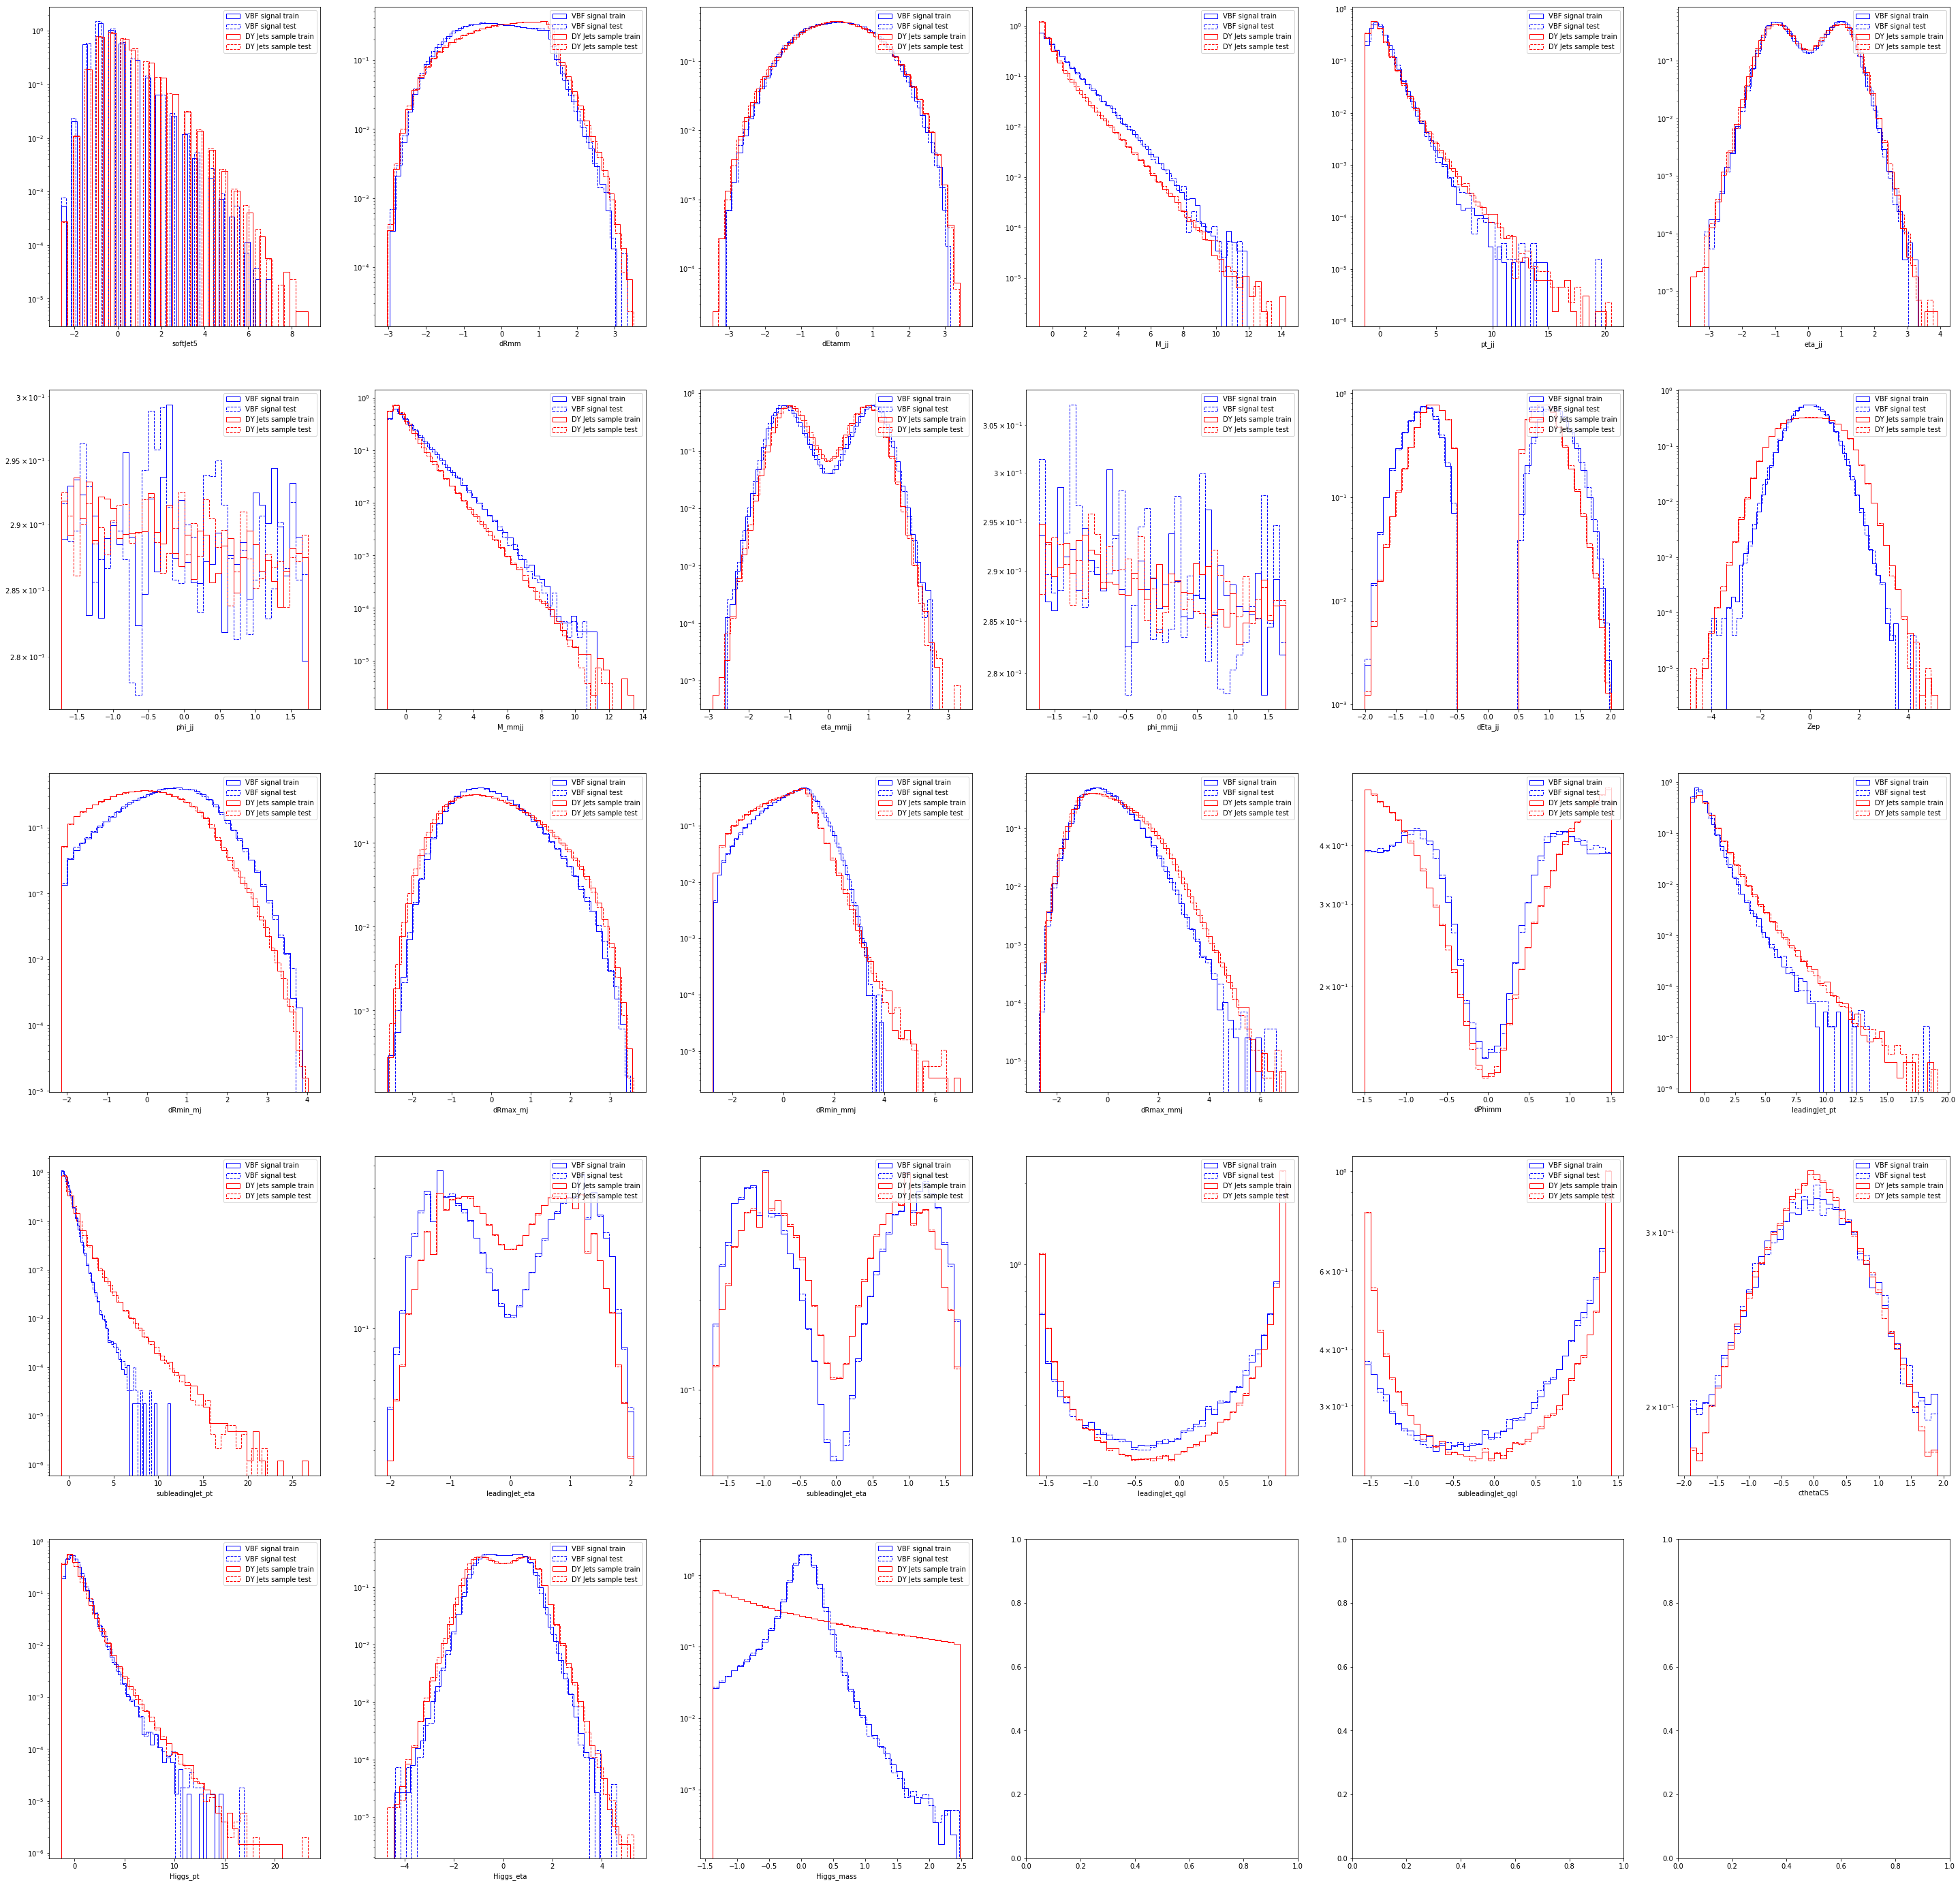

In [24]:
data_id=data[:,id_var_indices]
seed = 10
test_size = 0.4
#x_train, x_test, y_train, y_test, process_train, process_test  = train_test_split(data, label, process_label, test_size=test_size, random_state=seed)
x_train=data[data_id[:,2]%10 <6]
y_train=label[data_id[:,2]%10 <6]
process_train=process_label[data_id[:,2]%10 <6]
x_test=data[data_id[:,2]%10 >5]
y_test=label[data_id[:,2]%10 >5]
process_test=process_label[data_id[:,2]%10 >5]
print(y_test.shape)
is_sig_test = y_test==1
is_bkg_test = y_test==0
print(is_sig_test.shape)
z_train=x_train[:,mass_var_indices]
z_test = x_test[:,mass_var_indices]
# For training we ignore the columns with the event ID information

x_mean = np.mean(x_train[:,var_indices],axis=0)
x_std = np.std(x_train[:,var_indices],axis=0)
print(x_mean.shape,x_std.shape)


x_train[:,var_indices] = (x_train[:,var_indices]-x_mean)/x_std
x_test[:,var_indices] = (x_test[:,var_indices]-x_mean)/x_std
x_train_reduced = x_train[:,var_indices]
x_test_reduced = x_test[:,var_indices]
print(x_train_reduced.shape)
oldDNN_test=x_test[:,oldDNN_indices]
ucsd_bdt=x_test[:,ucsdBDT_indices]   
x_test_index = x_test[:,id_var_indices]
x_train_index = x_train[:,id_var_indices]

x_train_wt = x_train[:,wt_var_indices]
x_test_wt = x_test[:,wt_var_indices]
sig_test_wt_vbf=[]
sig_test_wt_ggh=[]
bkg_test_wt_dy_m105To160=[] #process_label 2
bkg_test_wt_dy_m105To160_vbf=[] #process_label 3
bkg_test_wt_ewk_m105To160=[] #process_label 4
for i in range(0,len(x_test_wt)):
    if y_test[i]==1:
        if(process_test[i]==1):sig_test_wt_vbf.append(x_test_wt[i])
        if(process_test[i]==-1):sig_test_wt_ggh.append(x_test_wt[i])
    if y_test[i]==0:
        if(process_test[i]==2):bkg_test_wt_dy_m105To160_vbf.append(x_test_wt[i])
        if(process_test[i]==3):bkg_test_wt_dy_m105To160.append(x_test_wt[i])
        if(process_test[i]==4):bkg_test_wt_ewk_m105To160.append(x_test_wt[i])
print(len(sig_test_wt_vbf))
print(len(sig_test_wt_ggh))
sig_vbf_sum = np.sum(sig_test_wt_vbf)
sig_ggh_sum = np.sum(sig_test_wt_ggh)
dy_m105To160_sum = np.sum(bkg_test_wt_dy_m105To160)
dy_m105To160_vbf_sum = np.sum(bkg_test_wt_dy_m105To160_vbf)
ewk_m105To160_sum = np.sum(bkg_test_wt_ewk_m105To160)

vbf_wt=np.sum(sig1_wt)+np.sum(sig2_wt)+np.sum(sig3_wt)
vbf_test_scale = vbf_wt/sig_vbf_sum
ggh_test_scale = ggh_wt/sig_ggh_sum
dy_m105to160_test_scale = dy_m105to160_wt/dy_m105To160_sum
dy_m105to160_vbf_test_scale = dy_m105to160_vbf_wt/dy_m105To160_vbf_sum
ewk_m105To160_test_scale = ewk_m105to160_wt/ewk_m105To160_sum

evt_weight=[]
print(np.sum(y_test))
for i in range(0,len(x_test_wt)):
    #print(process_test[i])
    if(process_test[i]==2):evt_weight.append(x_test_wt[i]*dy_m105to160_vbf_test_scale)
    elif(process_test[i]==1):evt_weight.append(x_test_wt[i]*vbf_test_scale)
    elif(process_test[i]==-1):evt_weight.append(x_test_wt[i]*ggh_test_scale)
    elif(process_test[i]==3):evt_weight.append(x_test_wt[i]*dy_m105to160_test_scale)
    elif(process_test[i]==4):evt_weight.append(x_test_wt[i]*ewk_m105To160_test_scale)
       
    
print(len(evt_weight))
print(np.sum(evt_weight))

print(x_train_reduced.shape, x_test_reduced.shape)
print(y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

print(x_train_reduced[:,0].shape)


####################################################################################################
##                         Check variables in the train and test samples                          ##
####################################################################################################
HLF = ['softJet5','dRmm','dEtamm','dPhimm','M_jj','pt_jj','eta_jj','phi_jj','M_mmjj',#'pt_mmjj',
       'eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
                                   ,'dRmin_mmj','dRmax_mmj',#'dPhijj',
       'leadingJet_pt','subleadingJet_pt',
                                   'leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS','Higgs_pt','Higgs_eta']

f, ax_arr = plt.subplots(5, 6, figsize=(50,50))

i=0
    
for j in range(0,5):
    for k in range(0,6):
        x_train_sig = []
        x_train_bkg =[]
        x_test_sig = []
        x_test_bkg = []
        x_train_sig_wt = []
        x_train_bkg_wt =[]
        x_test_sig_wt = []
        x_test_bkg_wt = []
        temp = x_train_reduced[:,i]
        test_tmp = x_test_reduced[:,i]
      
        for m in range (0,len(y_train)):
            if(y_train[m]==1): 
                x_train_sig.append(temp[m])
                x_train_sig_wt.append(x_train_wt[m])
            else: 
                x_train_bkg.append(temp[m])
                x_train_bkg_wt.append(x_train_wt[m])
        for m in range (0,len(y_test)): 
            if(y_test[m]==1): 
                x_test_sig.append(test_tmp[m])
                x_test_sig_wt.append(x_test_wt[m])
            else:
                x_test_bkg.append(test_tmp[m])   
                x_test_bkg_wt.append(x_test_wt[m])
        x_train_sig = np.array(x_train_sig) 
        x_train_sig_wt = np.array(x_train_sig_wt)
        x_test_sig = np.array(x_test_sig) 
        x_test_sig_wt = np.array(x_test_sig_wt)
        x_train_bkg = np.array(x_train_bkg) 
        x_train_bkg_wt = np.array(x_train_bkg_wt)
        x_test_bkg = np.array(x_test_bkg) 
        x_test_bkg_wt = np.array(x_test_bkg_wt)
        ax_arr[j,k].hist(x_train_sig, bins=40, histtype='step', label='VBF signal train',color='b',normed=True)#,weights=x_train_sig_wt)
        ax_arr[j,k].hist(x_test_sig, bins=40, histtype='step', linestyle =('dashed'), label='VBF signal test', color = 'b',normed=True)#,weights=x_test_sig_wt)
        ax_arr[j,k].hist(x_train_bkg, bins=40, histtype='step', label='DY Jets sample train',color='r',normed=True)#,weights=x_train_bkg_wt)
        ax_arr[j,k].hist(x_test_bkg, bins=40,  histtype='step', linestyle =('dashed'),label='DY Jets sample test', color = 'r',normed=True)#,weights=x_test_bkg_wt)
        ax_arr[j,k].set_xlabel(variables[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if i == 27: break
    if i ==27 : break
plt.show()  

## Fit function that trains a DNN

In [25]:
from scipy import interp
def fit( m_args, f_args):
    
    ###############################################################################################
    ##                                    DNN Classifier                                         ##
    ###############################################################################################
    m = make_model(**m_args)
    h = fit_model(m, x_train_reduced,y_train, x_train_wt.ravel(),**f_args)
    show_losses( [("VBF entropy", h)] )
    ## prediction on train samples

    return m

fit({'opt':sgd, 'b_norm': True, 'do': 0.1, 'n_hidden' : 3, 'hidden' : 100},{'batch_size' : 500})

W0913 09:43:09.458944 140302317336384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 09:43:09.577610 140302317336384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 09:43:09.638582 140302317336384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 09:43:09.640389 140302317336384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0913 09:43:09.656137 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 27)                0         
_________________________________________________________________
hidden_0 (Dense)             (None, 100)               2800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
__________

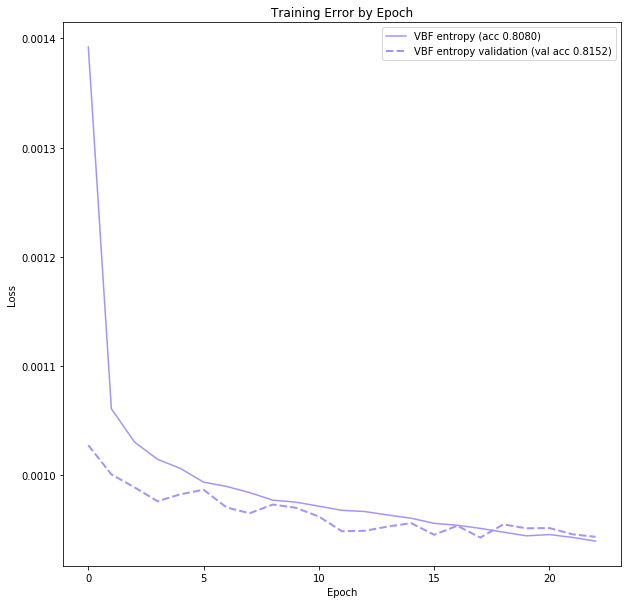

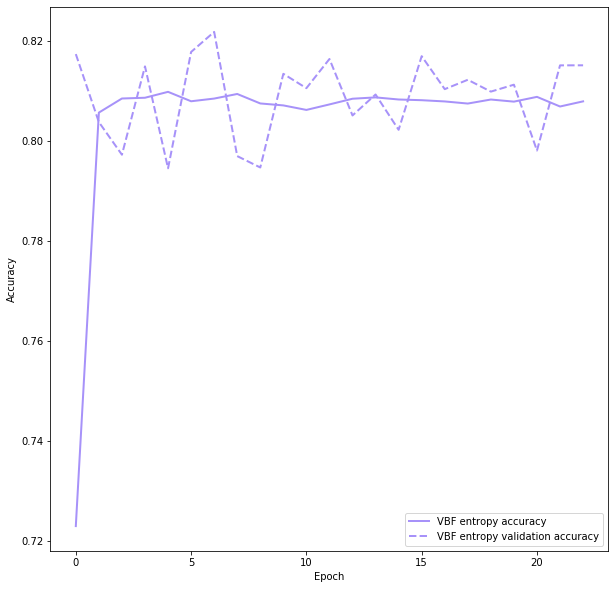

2019-09-13 09:43:14.413315: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-13 09:43:14.441951: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-09-13 09:43:15.743477: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x567b0e50 executing computations on platform CUDA. Devices:
2019-09-13 09:43:15.743527: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): TITAN Xp, Compute Capability 6.1
2019-09-13 09:43:15.824922: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199885000 Hz
2019-09-13 09:43:15.825689: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56d5ca40 executing computations on platform Host. Devices:
2019-09-13 09:43:15.825719: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefin

In [26]:
m1 = fit({'opt':'adam', 'b_norm': True, 'do': 0.2, 'n_hidden' : 3, 'hidden' : 100},{'batch_size' : 500})
y_pred_train_keras=m1.predict(x_train_reduced).ravel()
y_pred_keras = m1.predict(x_test_reduced).ravel()

In [27]:
def calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test ,x_test_wt,fpr_val=0.1):
    idx = (np.abs(fpr_keras - fpr_val)).argmin()
    print("tpr at fpr",fpr_val,":", round(tpr_keras[idx],2))
    print("threshold at fpr ",fpr_val,":",round(thresholds_keras[idx],2))
    Nsig = np.sum(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==1)])
    #Nsig=Nsig*1/sig_scale
    tmp=np.square(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==1)])
    Nsig_err=np.sum(tmp)
    Nsig_err=math.sqrt(Nsig_err)
    #Nsig_err=Nsig_err*1/sig_scale
    print("Nsig passing threshold: ", round(Nsig,2), " +/-" , round(Nsig_err,2))
    Nbkg =  np.sum(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==0)])
    tmp=np.square(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==0)])
    Nbkg_err=np.sum(tmp)
    Nbkg_err=math.sqrt(Nbkg_err)
    print("Nbkg passing threshold: ",round(Nbkg,2), " +/-" , round(Nbkg_err,2))
    #print("L :", math.sqrt(2*((Nsig+Nbkg)*np.log(1+(Nsig/Nbkg))-Nsig)))
    print("Nsig/sqrt(Nsig+Nbkg):", round(Nsig/math.sqrt(Nsig+Nbkg),2))

## Calculate significance

===============================[110.,150.]=============================================== GeV
========================================Caltech===========================
tpr at fpr 0.1 : 0.8
threshold at fpr  0.1 : 0.69
Nsig passing threshold:  8.54  +/- 0.05
Nbkg passing threshold:  339.2  +/- 6.25
Nsig/sqrt(Nsig+Nbkg): 0.46
tpr at fpr 0.01 : 0.31
threshold at fpr  0.01 : 0.95
Nsig passing threshold:  3.3  +/- 0.03
Nbkg passing threshold:  33.95  +/- 1.7
Nsig/sqrt(Nsig+Nbkg): 0.54
========================================UCSD==============================
tpr at fpr 0.1 : 0.77
threshold at fpr  0.1 : 0.6
Nsig passing threshold:  8.21  +/- 0.05
Nbkg passing threshold:  338.83  +/- 6.39
Nsig/sqrt(Nsig+Nbkg): 0.44
tpr at fpr 0.01 : 0.29
threshold at fpr  0.01 : 0.91
Nsig passing threshold:  3.03  +/- 0.03
Nbkg passing threshold:  33.87  +/- 1.81
Nsig/sqrt(Nsig+Nbkg): 0.5


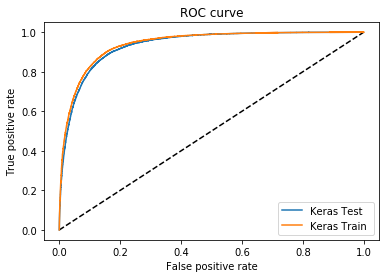

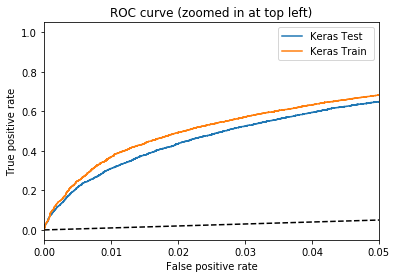

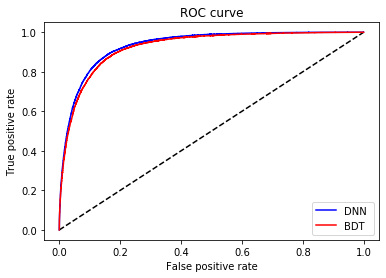

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


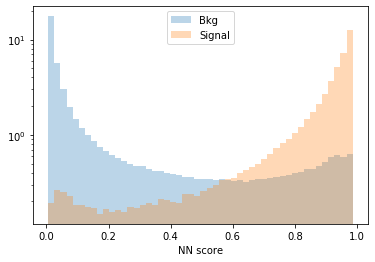

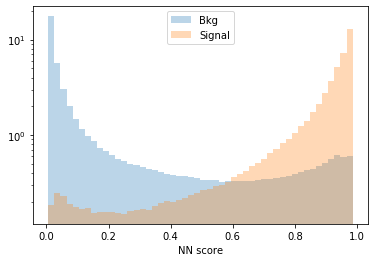

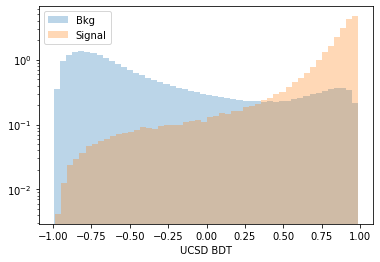

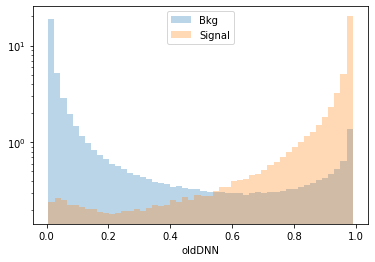

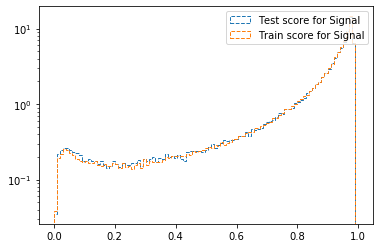

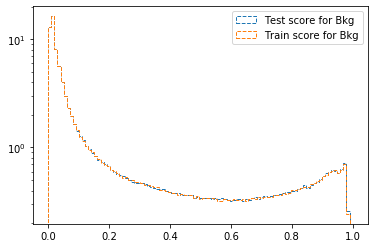

===============================[124.5.,125.5] GeV============================================
========================================Caltech===========================
tpr at fpr 0.1 : 0.42
threshold at fpr  0.1 : 0.95
Nsig passing threshold:  0.88  +/- 0.01
Nbkg passing threshold:  8.26  +/- 0.81
Nsig/sqrt(Nsig+Nbkg): 0.29
tpr at fpr 0.01 : 0.13
threshold at fpr  0.01 : 0.98
Nsig passing threshold:  0.27  +/- 0.01
Nbkg passing threshold:  0.82  +/- 0.28
Nsig/sqrt(Nsig+Nbkg): 0.26
========================================UCSD==============================
tpr at fpr 0.1 : 0.39
threshold at fpr  0.1 : 0.92
Nsig passing threshold:  0.82  +/- 0.01
Nbkg passing threshold:  8.27  +/- 0.86
Nsig/sqrt(Nsig+Nbkg): 0.27
tpr at fpr 0.01 : 0.13
threshold at fpr  0.01 : 0.97
Nsig passing threshold:  0.27  +/- 0.01
Nbkg passing threshold:  0.82  +/- 0.25
Nsig/sqrt(Nsig+Nbkg): 0.26


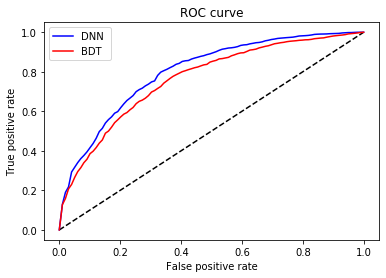

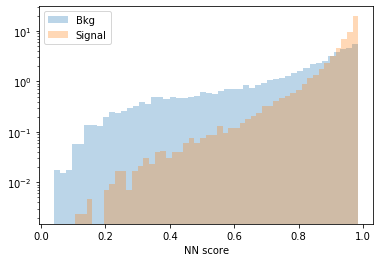

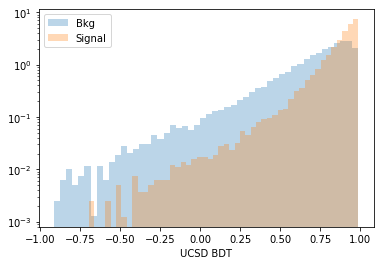

===========================================[120.,130.]=========================================== GeV
========================================Caltech===========================
tpr at fpr 0.1 : 0.54
threshold at fpr  0.1 : 0.91
Nsig passing threshold:  5.2  +/- 0.04
Nbkg passing threshold:  87.47  +/- 2.98
Nsig/sqrt(Nsig+Nbkg): 0.54
tpr at fpr 0.01 : 0.15
threshold at fpr  0.01 : 0.97
Nsig passing threshold:  1.43  +/- 0.02
Nbkg passing threshold:  8.7  +/- 0.76
Nsig/sqrt(Nsig+Nbkg): 0.45
========================================UCSD==============================
tpr at fpr 0.1 : 0.51
threshold at fpr  0.1 : 0.85
Nsig passing threshold:  4.94  +/- 0.04
Nbkg passing threshold:  87.46  +/- 3.12
Nsig/sqrt(Nsig+Nbkg): 0.51
tpr at fpr 0.01 : 0.15
threshold at fpr  0.01 : 0.95
Nsig passing threshold:  1.48  +/- 0.02
Nbkg passing threshold:  8.73  +/- 0.9
Nsig/sqrt(Nsig+Nbkg): 0.46


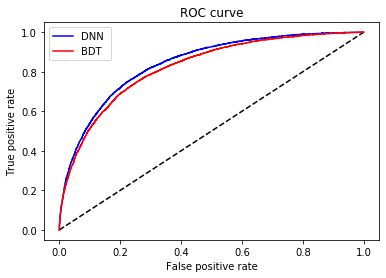

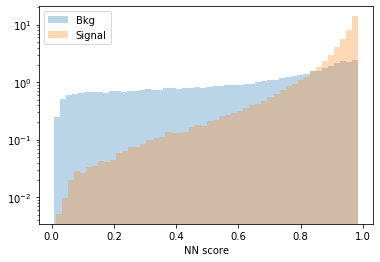

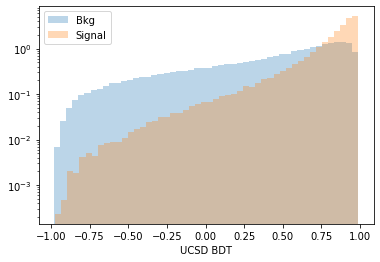

'\nCombined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt)\ns3_sig = (y_pred_keras_w2 >0.8) & (y_test_w2==1)\ns3_bkg = (y_pred_keras_w2 >0.8) & (y_test_w2==0)\nf, ax_arr = plt.subplots(5, 6, figsize=(50,50))\ni=0\nfor j in range(0,5):\n    for k in range(0,6):\n        test_tmp = x_test_reduced[:,i]\n        test_tmp = test_tmp[w2_t[:,0]]\n        ax_arr[j,k].hist(test_tmp[s3_sig], bins=40, histtype=\'step\', linestyle =(\'dashed\'), label=\'VBF signal test\', color = \'b\',weights=x_test_wt_w2[s3_sig])\n        ax_arr[j,k].hist(test_tmp[s3_bkg], bins=40, histtype=\'step\', label=\'ll+jj bkg\',color=\'r\',weights=x_test_wt_w2[s3_bkg])\n        ax_arr[j,k].set_xlabel(variables[i])\n        ax_arr[j,k].legend(prop={\'size\': 10})\n        ax_arr[j,k].legend(loc=\'best\')\n        ax_arr[j,k].set_yscale("log")\n        i+=1\n        if i == 27: break\n    if i ==27 : break\nplt.show()\n'

In [28]:
evt_weight=np.array(evt_weight)
print("===============================[110.,150.]=============================================== GeV")
fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_train, y_pred_train_keras,sample_weight=x_train_wt)

## predict on test samples
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras,sample_weight=x_test_wt)
print("========================================Caltech===========================")
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test,evt_weight, 0.1)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test,evt_weight, 0.01)

#ucsd_bdt=np.arctanh((ucsd_bdt+1)/2)
ucsd_bdt=x_test[:,ucsdBDT_indices]  
w2 = (z_train>120.) & (z_train<130.)
w2_t = (z_test>120.) & (z_test<130.)
w1 = (z_train>124.5) & (z_train<125.5)
w1_t = (z_test>124.5) & (z_test<125.5)

'''
#print(y_pred_keras.shape,y_test.shape,ucsd_bdt.shape,x_test_wt.shape,z_test.shape)
fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(y_test, oldDNN_test[:,0],sample_weight=x_test_wt)
calc_significance(fpr_bdt, tpr_bdt, thresholds_bdt,oldDNN_test[:,0], y_test,x_test_wt, 0.1)
calc_significance(fpr_bdt, tpr_bdt, thresholds_bdt,oldDNN_test[:,0], y_test ,x_test_wt,0.01)
'''
print("========================================UCSD==============================")
fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt = roc_curve(y_test, ucsd_bdt[:,0],sample_weight=x_test_wt)

calc_significance(fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt,ucsd_bdt[:,0], y_test,evt_weight, 0.1)
calc_significance(fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt,ucsd_bdt[:,0], y_test ,evt_weight,0.01)
#Combined_ROC(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt)
#Combined_ROC(fpr_bdt,tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt)
#DNN_ROC(fpr_keras,tpr_keras,auc_keras,fpr_keras_tmp,tpr_keras_tmp,auc_keras_tmp)    

DNN_ROC(fpr_keras,tpr_keras,fpr_keras_tmp,tpr_keras_tmp) 
Combined_ROC(fpr_keras,tpr_keras,fpr_ucsdbdt, tpr_ucsdbdt)
#Combined_ROC(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt)
score_classifier(y_test,y_pred_keras,'NN score')
score_classifier(y_train,y_pred_train_keras,'NN score')
score_classifier(y_test,ucsd_bdt[:,0],'UCSD BDT')
score_classifier(y_test,oldDNN_test[:,0],'oldDNN')

plt.figure(1)
plt.hist(y_pred_keras[y_test==1],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Test score for Signal')
plt.hist(y_pred_train_keras[y_train==1],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Train score for Signal')
plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.hist(y_pred_keras[y_test==0],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Test score for Bkg')
plt.hist(y_pred_train_keras[y_train==0],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Train score for Bkg')
plt.yscale('log')
plt.legend(loc='best')
plt.show()
'''

#Combined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt)
s1_sig = (y_pred_keras >0.8) & (y_test==1)
s1_bkg = (y_pred_keras >0.8) & (y_test==0)
f, ax_arr = plt.subplots(5, 6, figsize=(50,50))
i=0
for j in range(0,5):
    for k in range(0,6):
        test_tmp = x_test_reduced[:,i]
        ax_arr[j,k].hist(test_tmp[s1_sig], bins=40, histtype='step', linestyle =('dashed'), label='VBF signal test', color = 'b',weights=x_test_wt[s1_sig])
        ax_arr[j,k].hist(test_tmp[s1_bkg], bins=40, histtype='step', label='ll+jj bkg',color='r',weights=x_test_wt[s1_bkg])
        ax_arr[j,k].set_xlabel(variables[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if i == 27: break
    if i ==27 : break
plt.show()  
'''
print("===============================[124.5.,125.5] GeV============================================")

y_pred_keras_w1 = y_pred_keras[w1_t[:,0]]
y_test_w1 = y_test[w1_t[:,0]]
x_test_wt_w1 = evt_weight[w1_t[:,0]]
#print(y_pred_keras_w1.shape,y_test_w1.shape,x_test_wt_w1.shape)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_w1, y_pred_keras_w1,sample_weight=x_test_wt_w1)


fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt = roc_curve(y_test_w1, ucsd_bdt[w1_t],sample_weight=x_test_wt_w1)

mean_fpr = np.linspace(0., 1., 100)
tprs = interp(mean_fpr, fpr_keras, tpr_keras)
ths= interp(mean_fpr, fpr_keras, thresholds_keras)

tprs_bdt = interp(mean_fpr, fpr_ucsdbdt, tpr_ucsdbdt)
ths_bdt = interp(mean_fpr, fpr_ucsdbdt, thresholds_ucsdbdt)

print("========================================Caltech===========================")
calc_significance(mean_fpr, tprs, ths,y_pred_keras_w1, y_test_w1,x_test_wt_w1, 0.1)
calc_significance(mean_fpr, tprs, ths,y_pred_keras_w1, y_test_w1,x_test_wt_w1, 0.01)
print("========================================UCSD==============================")
calc_significance(mean_fpr, tprs_bdt, ths_bdt,ucsd_bdt[w1_t], y_test_w1,x_test_wt_w1, 0.1)
calc_significance(mean_fpr, tprs_bdt, ths_bdt,ucsd_bdt[w1_t], y_test_w1,x_test_wt_w1, 0.01)


Combined_ROC(mean_fpr,tprs,mean_fpr, tprs_bdt)

score_classifier(y_test_w1,y_pred_keras_w1,'NN score')
#score_classifier(y_test,oldDNN_test[w1_t],'oldDNN')
score_classifier(y_test_w1,ucsd_bdt[w1_t],'UCSD BDT')
'''
Combined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt)
s2_sig = (y_pred_keras_w1 >0.8) & (y_test_w1==1)
s2_bkg = (y_pred_keras_w1 >0.8) & (y_test_w1==0)
f, ax_arr = plt.subplots(5, 6, figsize=(50,50))
i=0
for j in range(0,5):
    for k in range(0,6):
        test_tmp = x_test_reduced[:,i]
        test_tmp = test_tmp[w1_t[:,0]]
        ax_arr[j,k].hist(test_tmp[s2_sig], bins=40, histtype='step', linestyle =('dashed'), label='VBF signal test', color = 'b',weights=x_test_wt_w1[s2_sig])
        ax_arr[j,k].hist(test_tmp[s2_bkg], bins=40, histtype='step', label='ll+jj bkg',color='r',weights=x_test_wt_w1[s2_bkg])
        ax_arr[j,k].set_xlabel(variables[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if i == 27: break
    if i ==27 : break
plt.show()  
'''
print("===========================================[120.,130.]=========================================== GeV")
y_pred_keras_w2 = y_pred_keras[w2_t[:,0]]
y_test_w2 = y_test[w2_t[:,0]]
x_test_wt_w2 = evt_weight[w2_t[:,0]]
print("========================================Caltech===========================")

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_w2, y_pred_keras_w2,sample_weight=x_test_wt_w2)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_w2, y_test_w2, x_test_wt_w2,0.1)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_w2, y_test_w2,x_test_wt_w2, 0.01)

print("========================================UCSD==============================")
fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt = roc_curve(y_test_w2, ucsd_bdt[w2_t],sample_weight=x_test_wt_w2)
calc_significance(fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt,ucsd_bdt[w2_t], y_test_w2,x_test_wt_w2, 0.1)
calc_significance(fpr_ucsdbdt, tpr_ucsdbdt, thresholds_ucsdbdt,ucsd_bdt[w2_t], y_test_w2,x_test_wt_w2, 0.01)

Combined_ROC(fpr_keras,tpr_keras,fpr_ucsdbdt, tpr_ucsdbdt)

score_classifier(y_test_w2,y_pred_keras_w2,'NN score')
#score_classifier(y_test,oldDNN_test[w2_t],'oldDNN')
score_classifier(y_test_w2,ucsd_bdt[w2_t],'UCSD BDT')
'''
Combined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt)
s3_sig = (y_pred_keras_w2 >0.8) & (y_test_w2==1)
s3_bkg = (y_pred_keras_w2 >0.8) & (y_test_w2==0)
f, ax_arr = plt.subplots(5, 6, figsize=(50,50))
i=0
for j in range(0,5):
    for k in range(0,6):
        test_tmp = x_test_reduced[:,i]
        test_tmp = test_tmp[w2_t[:,0]]
        ax_arr[j,k].hist(test_tmp[s3_sig], bins=40, histtype='step', linestyle =('dashed'), label='VBF signal test', color = 'b',weights=x_test_wt_w2[s3_sig])
        ax_arr[j,k].hist(test_tmp[s3_bkg], bins=40, histtype='step', label='ll+jj bkg',color='r',weights=x_test_wt_w2[s3_bkg])
        ax_arr[j,k].set_xlabel(variables[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if i == 27: break
    if i ==27 : break
plt.show()
'''

## Check ROC curve for VBF only

========================================Caltech===========================
tpr at fpr 0.1 : 0.84
threshold at fpr  0.1 : 0.69
Nsig passing threshold:  5.36  +/- 0.02
Nbkg passing threshold:  339.2  +/- 6.25
Nsig/sqrt(Nsig+Nbkg): 0.29
tpr at fpr 0.01 : 0.4
threshold at fpr  0.01 : 0.95
Nsig passing threshold:  2.54  +/- 0.02
Nbkg passing threshold:  33.95  +/- 1.7
Nsig/sqrt(Nsig+Nbkg): 0.42
tpr at fpr 0.001 : 0.11
threshold at fpr  0.001 : 0.98
Nsig passing threshold:  0.69  +/- 0.01
Nbkg passing threshold:  3.39  +/- 0.52
Nsig/sqrt(Nsig+Nbkg): 0.34


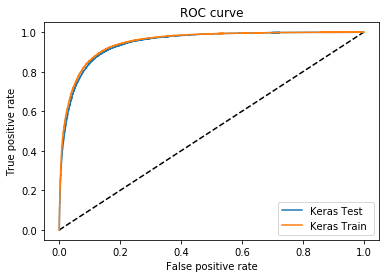

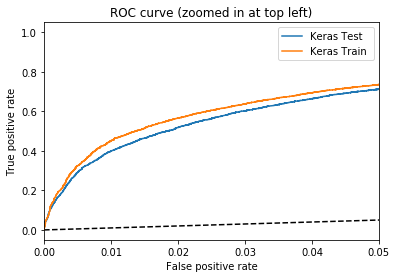

In [29]:
y_train_vbf = y_train[(process_train>0)]
y_pred_train_keras_vbf=y_pred_train_keras[(process_train>0)]
y_test_vbf = y_test[(process_test>0)]
y_pred_keras_vbf = y_pred_keras[(process_test>0)]
x_train_wt_vbf = x_train_wt[(process_train>0)]
x_test_wt_vbf = x_test_wt[(process_test>0)]
evt_weight_vbf = evt_weight[(process_test>0)]
fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_train_vbf, y_pred_train_keras_vbf,sample_weight=x_train_wt_vbf)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_vbf, y_pred_keras_vbf,sample_weight=x_test_wt_vbf)
print("========================================Caltech===========================")
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_vbf, y_test_vbf,evt_weight_vbf, 0.1)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_vbf, y_test_vbf,evt_weight_vbf, 0.01)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_vbf, y_test_vbf,evt_weight_vbf, 0.001)
DNN_ROC(fpr_keras,tpr_keras,fpr_keras_tmp,tpr_keras_tmp) 

## Save training to disk